## **Simulating Data for Python Didactics**
### PTSD and Suicidal Ideation: 
#### **Author(s)**: Dominic DiSanto
#### **Written**: 9/28/2020
#### **Updated**: 10/07/2020
#### **Version**: 0.1



In [1]:
import scipy as sci
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(1415)

#### General Process
***This notebook follows the following general steps/sections:***
   1. Generate random patient identifiers (somewhat superfluous but makes the data feel "genuine"
   2. Generating the early "research cohort identification" random ICD data 
   2. Generate simulated PTSD survey data 
   3. Generate simulated suicidal ideation (specifically PHQ-9) data
   4. Generate relevant covariates containing relevant relationships and "noise" 
   5. Generate prescription data with the desired relatioships to outcomes of interest
   6. Export data   
     
***Steps Outside of This Notebook***
   1. Upload relevant files to GitHub and organize in a presentable format 
   2. Refine/finalize draft of student assessment document 
   3. Develop notebook that works through proposed "solution" and outlines markers of successful completion/competency

## (1) Generating Patient Identifier
Random alphanumeric variable, just mirroring the structure of identifiers at my previousl clinical research lab for a bit of nostalgia. Nothing too special or even necessary about using these (no merging currently) 

In [2]:
ids = []

while len(ids)<401: # while loop instead of for to prevent any duplicates
    new_id = chr(np.random.choice([85, 90], 1)) + str(np.random.choice(range(100, 999), 1)[0])
    if new_id not in ids:
        ids.append(new_id)

In [3]:
ptsd_df = pd.DataFrame(data=ids, columns=['UID'])
ptsd_df.head()

,UID
0,U200
1,U398
2,Z812
3,U221
4,U338


### (2) Generate random ICD data

This is used for the first question in the student assessment, which prompts students to identify a research cohort definition. The focus will be on adults with a PTSD diagnosis. I will sample a subset of "mental distress" codes (very loosely) and the PTSD diagnosis code. I will mix both ICD9 and ICD10 codes. 

I will simulate age data as well. I will include more positive diagnoses of PTSD than are included in our final data set (and will ensure they are all adults), simulating some "loss to follow-up" in the analytic cdataset compared to the "identified possibel research cohort. 

In [4]:
# Importing this from CMS to sample ICD codes
# (https://www.cms.gov/Medicare/Coding/ICD9ProviderDiagnosticCodes/codes)
icd9 = pd.read_excel(r'C:\Users\Dominic DiSanto\Documents\Grad School' + \
                     r'\PHARM_Python\Use Cases\PTSD_Britney\ICD-9-CM-v32-master-descriptions' +\
                     '\CMS32_DESC_LONG_SHORT_DX.xlsx')

In [5]:
icd9['SHORT DESCRIPTION'] = icd9['SHORT DESCRIPTION'].str.lower()
icd9['LONG DESCRIPTION'] = icd9['LONG DESCRIPTION'].str.lower()

In [6]:
icd9.head()

,DIAGNOSIS CODE,LONG DESCRIPTION,SHORT DESCRIPTION
0,0010,cholera due to vibrio cholerae,cholera d/t vib cholerae
1,0011,cholera due to vibrio cholerae el tor,cholera d/t vib el tor
2,0019,"cholera, unspecified",cholera nos
3,0020,typhoid fever,typhoid fever
4,0021,paratyphoid fever a,paratyphoid fever a


In [7]:
# Found a nice csv of icd10 codes (https://github.com/kamillamagna/ICD-10-CSV)
icd10 = pd.read_csv(r'C:\Users\Dominic DiSanto\Documents\Grad School\PHARM_Python\Use Cases\\' +\
                 r'PTSD_Britney\icd10codes.csv', 
                   names=['Code_Pre', 'Code_Suff', 'Code', 'Descr', 'Descr2', 'ShortDescr'])
icd10 = icd10[['Code', 'Descr']]

Identifying codes to include (other than the PTSD codes of interest, e.g. some "noise")

In [8]:
mental_icd = icd10.loc[icd10['Descr'].str.contains('mental'), 'Code'].append(
    icd9.loc[icd9['SHORT DESCRIPTION'].str.contains('mental'), 'DIAGNOSIS CODE'])

Creating a sample of these noisy codes, then assigning random patient identifiers 

In [9]:
icd_data=np.append(np.random.choice(mental_icd, size=9400, replace=True), 
         np.random.choice(['309.81', 'F43.10', 'F43.11', 'F43.12'], size=600, replace=True))


Lastly generating some age data, hoping to get some peds and some older folks

In [10]:
icd_dict = {
    'PatientID': np.random.choice(range(1, 999), 10000, replace=True),
    'ICDCode': icd_data,
}

In [11]:
age = np.random.normal(34, 16, len(set(icd_dict['PatientID'])))

age[age<14] = 14
age[age>70] = 70
age = np.round(age, 0).astype(int)

age_df = pd.DataFrame(
    {'PatientID': np.random.choice(list(set(icd_dict['PatientID'])), size=len(age), replace=False),
    'Age': age}
)

In [12]:
len(icd_dict['PatientID'])

10000

In [13]:
icd_extract_df = pd.merge(pd.DataFrame(icd_dict).sort_values('PatientID'),
                       age_df,
                       on='PatientID', how='outer')

# Ensuring all of our diagnosis of interest are 
#icd_extract_df

In [14]:
#for i in icd_extract_df[icd_extract_df['ICDCode'].str.contains('309.81|F43.10|F43.11|F43.12')].index:
#    icd_extract_df.loc[i, 'Age'] = min(65, max(18, icd_extract_df.loc[i, 'Age']))

# this loop ensures at least slightly more than the analytic cohort in the remaining assessment are
# of the correct age range and with a PTSD diagnosis for "inclusion" in the study 
if icd_extract_df[(icd_extract_df['ICDCode'].str.contains('309.81|F43.10|F43.11|F43.12')) & 
              (icd_extract_df['Age']>18) & (icd_extract_df['Age']<65)].shape[0]<401:
    for i in np.random.choice(icd_extract_df[
        icd_extract_df['ICDCode'].str.contains('309.81|F43.10|F43.11|F43.12')].index,
                    size=450, replace=False):
        icd_extract_df[i, 'Age'] = max(18, min(64, icd_extract_df[i, 'Age']))

In [15]:
icd_extract_df[(icd_extract_df['ICDCode'].str.contains('309.81|F43.10|F43.11|F43.12')) & 
              (icd_extract_df['Age']>18) & (icd_extract_df['Age']<65)]

,PatientID,ICDCode,Age
79,9,F43.10,28
82,10,309.81,32
90,11,F43.12,49
120,15,309.81,57
123,15,309.81,57
...,...,...,...
9937,993,F43.10,51
9938,993,F43.12,51
9953,994,F43.12,33
9957,994,F43.12,33


In [16]:
icd_extract_df.to_csv('PossiblePatients_ICD.csv')

## (2) Generating 6-month PTSD Data
Using the [PTSD Civilian Checklist - Version 5](https://www.ptsd.va.gov/professional/assessment/documents/PCL5_Standard_form.PDF) to generate data usable for PTSD symptom assessment and diagnosis. Data includes 20 Likert Scale measured questions. I will begin by creating the 6-month outcome variable. From this variable, I will create other covariates with relationships/correlations of interest:

In [17]:
for i in range(1, 21): # generate random PTSD data with little-to-no positive diagnoses
    ptsd_df['PTSD_Q' + str(i) + '_6mo'] = np.random.choice(range(0, 5),
                                                           size=ptsd_df.shape[0], replace=True,
                                                          p=[0.4, 0.3, 0.15, 0.1, 0.05])

# randomly sample ~40% of the population and give them diagnoses
#sample = np.random.randint(0, high=ptsd_df.shape[0], size=int(np.floor(ptsd_df.shape[0]/2)))

#for i in range(1, 21): 
#    for j in sample:
#        ptsd_df.loc[j, 'PTSD_Q' + str(i) + '_6mo'] = np.random.choice(range(0, 5),
#                                                           size=1, replace=True,
#                                                          p=[0.1, 0.2, 0.4, 0.15, 0.15])

#ptsd_df.loc[sample].head()

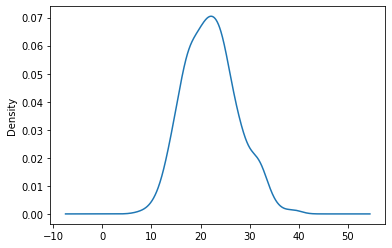

In [18]:
ptsd_df[[col for col in ptsd_df.columns if col.startswith('PTSD') and 
                                           col.endswith('6mo')]].sum(axis=1).plot.density()
plt.show()

In [19]:
#### Generating PTSD Variable (code also included in walkthrough
for i in range(0, ptsd_df.shape[0]):
    if min(max(ptsd_df.iloc[i, 1:6]), max(ptsd_df.iloc[i, 6:8]), 
           max(ptsd_df.iloc[i, 8:15]), max(ptsd_df.iloc[i, 15:21]))>=2:
        ptsd_df.loc[i, 'PTSD_6mo'] = 1
    else:
        ptsd_df.loc[i, 'PTSD_6mo'] = 0


In [20]:
ptsd_df['PTSD_6mo'].value_counts()

0.0    258
1.0    143
Name: PTSD_6mo, dtype: int64

## (3) Generating 6-Month SRB Data (PHQ-9)
Using the [Patient-Health-Questionnaire (PHQ-9)](https://www.mdcalc.com/phq-9-patient-health-questionnaire-9) to assess symptom of suicidal "ideation" or "endorsement". I did not generate the first 8 questions, as these were not used and I thought we could keep the data cleaning simple (at least compared to the VA use case or other "data annoyance" use cases). We can always generate these other 8 questions/variables later, and have students generate a depression symptom inventory sum score as a feature (which is a fairly simple data simin teh loop below and simple data cleaning with a row sum). 

*I don't currently include an lit references for PHQ-9 but can pull info for both the use of it in assessing suicidality and generally in depression*

In [21]:
#for i in range(1, 9): # Omitting non suicidal ideation related PHQ0 questions for now simply for 
                       # brevity/simplicity. Easy to add in if we want students to clean and use a 
                       # depression symptom inventory as a feature. 
#    ptsd_df['PHQ_Q' + str(i) + '_6mo'] = np.random.choice(range(0, 4),
#                                                           size=ptsd_df.shape[0], replace=True)

ptsd_df.loc[ptsd_df['PTSD_6mo']==0, 'PHQ_Q9_6mo'] = np.random.choice(range(0, 4),
                                                   size=ptsd_df.loc[ptsd_df['PTSD_6mo']==0].shape[0],
                                                                    replace=True, 
                                                                    p=[0.65, 0.15, 0.1, 0.1])

ptsd_df.loc[ptsd_df['PTSD_6mo']==1, 'PHQ_Q9_6mo'] = np.random.choice(range(0, 4),
                                                   size=ptsd_df.loc[ptsd_df['PTSD_6mo']==1].shape[0],
                                                                    replace=True, 
                                                                    p=[0.45, 0.25, 0.2, 0.1])

ptsd_df.head()

,UID,PTSD_Q1_6mo,PTSD_Q2_6mo,PTSD_Q3_6mo,PTSD_Q4_6mo,PTSD_Q5_6mo,PTSD_Q6_6mo,PTSD_Q7_6mo,PTSD_Q8_6mo,PTSD_Q9_6mo,...,PTSD_Q13_6mo,PTSD_Q14_6mo,PTSD_Q15_6mo,PTSD_Q16_6mo,PTSD_Q17_6mo,PTSD_Q18_6mo,PTSD_Q19_6mo,PTSD_Q20_6mo,PTSD_6mo,PHQ_Q9_6mo
0,U200,1,0,0,0,0,1,0,1,0,...,4,2,2,0,0,1,0,0,0.0,0.0
1,U398,0,1,2,2,0,1,0,3,0,...,2,1,1,1,2,0,0,2,0.0,0.0
2,Z812,2,1,1,2,0,1,1,0,0,...,0,1,0,1,0,1,0,4,0.0,0.0
3,U221,0,0,0,0,1,1,2,1,3,...,0,2,3,1,0,0,3,0,0.0,0.0
4,U338,2,1,0,1,1,0,0,0,0,...,2,0,1,2,0,0,1,0,0.0,2.0


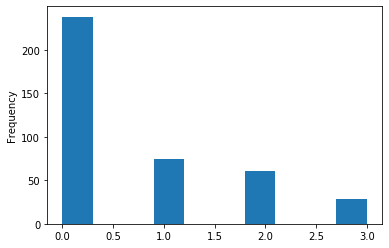

In [22]:
ptsd_df['PHQ_Q9_6mo'].plot.hist()
plt.show()

In [23]:
ptsd_df['SRB_6mo'] = np.where(ptsd_df['PHQ_Q9_6mo']==0, 0, 1)

In [24]:
for i in set(ptsd_df['PTSD_6mo']):
    freq = ptsd_df.loc[ptsd_df['PTSD_6mo']==i, 'SRB_6mo'].value_counts()[1]
    pct = round(ptsd_df.loc[ptsd_df['PTSD_6mo']==i, 'SRB_6mo'].value_counts()[1] / \
    ptsd_df.loc[ptsd_df['PTSD_6mo']==i].shape[0], 4)*100
    print('For patients with PTSD Diagnosis of ' + str(i) + ', ' + str(freq) + ' (' + str(pct) + 
          '%) has a positive diagnosis of SRB.')

For patients with PTSD Diagnosis of 0.0, 84 (32.56%) has a positive diagnosis of SRB.
For patients with PTSD Diagnosis of 1.0, 79 (55.24%) has a positive diagnosis of SRB.


## (4) Generating Covariates

### (4a) Age
Normal distribution, and I somewhat arbitrarily created relationships here by different combinations of SRB and PTSD. I didn't pull literature to justify these relationships, simply thought of ones that may be reasonable. Each "if" clause generates a different normal distribution of age, with younger patients being susceptible to suicidal behavior, and middle-young age patients more likely to present both SRB and PTSD at 6-months. 

In [25]:
ptsd_df['Age']=np.nan

for i in range(0, ptsd_df.shape[0]):
    if ptsd_df.loc[i, 'PTSD_6mo']==1 and ptsd_df.loc[i, 'SRB_6mo']==1:
        ptsd_df.loc[i, 'Age'] = round(max(np.random.normal(25, 3), 18), 0)
    if ptsd_df.loc[i, 'PTSD_6mo']==1 and ptsd_df.loc[i, 'SRB_6mo']==0:
        ptsd_df.loc[i, 'Age'] = round(max(np.random.normal(40, 6), 18), 0)
    if ptsd_df.loc[i, 'PTSD_6mo']==0 and ptsd_df.loc[i, 'SRB_6mo']==1:
        ptsd_df.loc[i, 'Age'] = round(max(np.random.normal(19, 1), 18), 0)
    if ptsd_df.loc[i, 'PTSD_6mo']==0 and ptsd_df.loc[i, 'SRB_6mo']==0:
        ptsd_df.loc[i, 'Age'] = round(max(np.random.normal(40, 10), 18), 0)

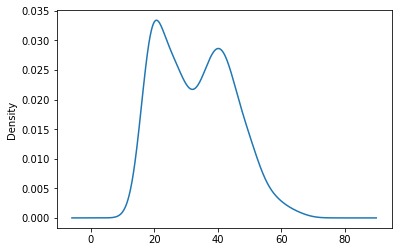

In [26]:
ptsd_df['Age'].plot.density()

In [27]:
ptsd_df[['Age', 'PTSD_6mo', 'SRB_6mo']].groupby(['PTSD_6mo', 'SRB_6mo']).agg({
    'Age':['count', 'mean', 'std']
    })

Age                     
                 count       mean       std
PTSD_6mo SRB_6mo                           
0.0      0         174  40.706897  9.078989
         1          84  18.964286  0.813240
1.0      0          64  40.500000  6.156684
         1          79  25.468354  3.054360

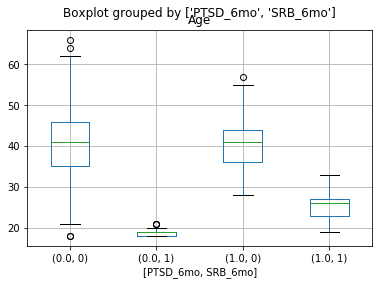

In [28]:
ptsd_df.boxplot(column='Age', by=['PTSD_6mo', 'SRB_6mo'])

### (4b) Years Since First Diagnosis

I thought this might "appear" to be a variable related to PTSD and/or SRB, but I decided to generate this as a noisy variable simply to distinguish it from the medication and other predictors. If we want to better link relationships in this model to existing research, may want to explore identifying a justified relationship to create for this variable. 

In [29]:
## Commented code was used to generate a density plot, check if the distribution was what
## I generally wanted 
#from scipy.stats import gaussian_kde
yrs = (np.random.beta(0.78, 0.78, size=ptsd_df.shape[0])+1)*12
ptsd_df['TimeFirstDiagnosis_Months'] = yrs.round(0)
#density = gaussian_kde(yrs)
#xs = np.linspace(min(yrs), max(yrs), 100)
#density.covariance_factor = lambda : .25
#density._compute_covariance()
#plt.plot(xs,density(xs))
#plt.show()

In [30]:
ptsd_df['TimeFirstDiagnosis_Months']

0      18.0
1      17.0
2      18.0
3      24.0
4      16.0
       ... 
396    21.0
397    21.0
398    21.0
399    20.0
400    17.0
Name: TimeFirstDiagnosis_Months, Length: 401, dtype: float64

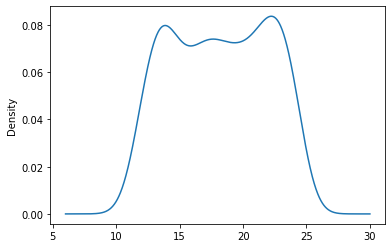

In [31]:
ptsd_df['TimeFirstDiagnosis_Months'].plot.density()

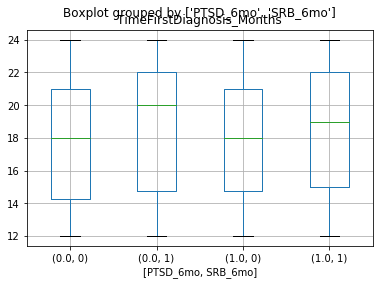

In [32]:
ptsd_df.boxplot(column='TimeFirstDiagnosis_Months', by=['PTSD_6mo', 'SRB_6mo'])

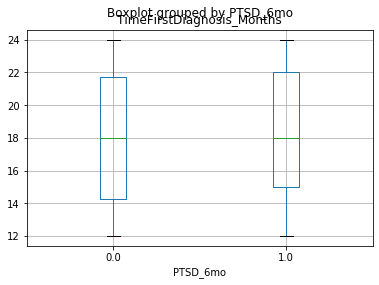

In [33]:
ptsd_df.boxplot(column='TimeFirstDiagnosis_Months', by='PTSD_6mo')

### (4c) Combat Deployment
We will set this related to PTSD but not suicidality (simply a binomial where we manually set probabilities).

**11/11/2020 -- Omitting this for now, and treating this as a civilian population**

In [34]:
#ptsd_df['CombatExposure'] = np.nan
#
#for i in range(0, ptsd_df.shape[0]):
#    if ptsd_df.loc[i, 'PTSD_6mo']==1:
#        ptsd_df.loc[i, 'CombatExposure'] = np.random.choice([0, 1], p=[0.02, 0.98])
#    else:
#        ptsd_df.loc[i, 'CombatExposure'] = np.random.choice([0, 1], p=[0.6, 0.4])
        

In [35]:
#ptsd_df[['CombatExposure', 'PTSD_6mo']].groupby(['CombatExposure', 'PTSD_6mo']).size().\
#reset_index(name='counts')

In [36]:
#ptsd_df[['CombatExposure', 'SRB_6mo']].groupby(['CombatExposure', 'SRB_6mo']).size().\
#reset_index(name='counts')

### (4d) Exposure to IEDs
Within patients with a positive combat deployment indicator, I've also created an improvised explosive device (IED) indicator, which is additionally related to PTSD. This variable may end up being dropped in favor of a better feature/predictor, but this is something that I thought fit well within the combat exposure variable (also at the cost of including some fairly morbid features). 

**11-11-2020 -- Omitting this for now, and treatin this as a civilian population**

In [37]:
#ptsd_df['IED_Exposure'] = np.nan
#
#for i in range(0, ptsd_df.shape[0]):
#    if ptsd_df.loc[i, 'CombatExposure']==1 and ptsd_df.loc[i, 'PTSD_6mo']==0:
#        ptsd_df.loc[i,'IED_Exposure'] = np.random.choice([0, 1], p=[0.85, 0.15])
#    if ptsd_df.loc[i, 'CombatExposure']==1 and ptsd_df.loc[i, 'PTSD_6mo']==1:
#        ptsd_df.loc[i,'IED_Exposure'] = np.random.choice([0, 1], p=[0.7, 0.3])
#    if np.isnan(ptsd_df.loc[i, 'IED_Exposure']):
#        ptsd_df.loc[i,'IED_Exposure'] = 0
#        

In [38]:
#ptsd_df[['IED_Exposure', 'PTSD_6mo']].groupby(['IED_Exposure', 'PTSD_6mo']).size().\
#reset_index(name='counts')

In [39]:
#ptsd_df[['IED_Exposure', 'SRB_6mo']].groupby(['IED_Exposure', 'SRB_6mo']).size().\
#reset_index(name='counts')

In [40]:
#ptsd_df[['IED_Exposure', 'CombatExposure']].groupby(['IED_Exposure', 'CombatExposure']).size().\
#reset_index(name='counts')

### (4e) Alcohol Abuse
Binary variable, more frequent among patients who endorse suicidal ideation

In [41]:
ptsd_df['AlcAbuse'] = np.nan

for i in range(0, ptsd_df.shape[0]):
    if ptsd_df.loc[i, 'SRB_6mo']==1 and ptsd_df.loc[i, 'PTSD_6mo']==1:
        ptsd_df.loc[i, 'AlcAbuse'] = np.random.choice([0, 1], p=[0.3, 0.7])
    if ptsd_df.loc[i, 'SRB_6mo']==1 and ptsd_df.loc[i, 'PTSD_6mo']==0:
        ptsd_df.loc[i, 'AlcAbuse'] = np.random.choice([0, 1], p=[0.5, 0.5])
    if np.isnan(ptsd_df.loc[i, 'AlcAbuse']):
        ptsd_df.loc[i, 'AlcAbuse'] = np.random.choice([0, 1], p=[0.7, 0.3])
        

In [42]:
ptsd_df[['AlcAbuse', 'PTSD_6mo']].groupby(['AlcAbuse', 'PTSD_6mo']).size().\
reset_index(name='counts')

,AlcAbuse,PTSD_6mo,counts
0,0.0,0.0,166
1,0.0,1.0,68
2,1.0,0.0,92
3,1.0,1.0,75


In [43]:
ptsd_df[['AlcAbuse', 'SRB_6mo']].groupby(['AlcAbuse', 'SRB_6mo']).size().\
reset_index(name='counts')

,AlcAbuse,SRB_6mo,counts
0,0.0,0,167
1,0.0,1,67
2,1.0,0,71
3,1.0,1,96


In [44]:
ptsd_df['SRB_6mo'].value_counts()

0    238
1    163
Name: SRB_6mo, dtype: int64

### (4f) Beck Anxiety Inventory
~~Another noisy predictor (using my rudimentary understanding of the [AFQT](https://en.wikipedia.org/wiki/Armed_Services_Vocational_Aptitude_Battery#Armed_Forces_Qualification_Test), assigning scores in a random, normal distribution from 0 to 100)~~

11/11/2020: Updated to be civilian data, moved to the Beck Anxiety Inventory 

In [45]:
ptsd_df['BeckAnxiety_BL'] = np.random.normal(loc=15, scale=15, size=ptsd_df.shape[0]).round(0)

ptsd_df.loc[ptsd_df['BeckAnxiety_BL']<0, 'BeckAnxiety_BL'] = 0
ptsd_df.loc[ptsd_df['BeckAnxiety_BL']>63, 'BeckAnxiety_BL'] = 63

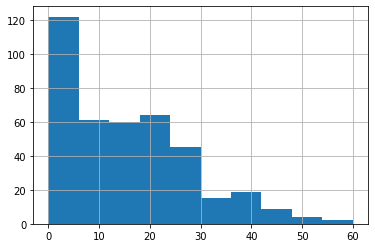

In [46]:
ptsd_df['BeckAnxiety_BL'].hist()

### (4g) Income
Generating as a four-tiered variable, so students will have to dummy or one-hot encode (forcing some EDA and only minor data cleaning, but always some). I simply made four categories generally related to the federal poverty line (just as a standard to which to compare). 

- At/below 125% of poverty line
- Between 125 and 200% of federal poverty line
- Between 200% and 400% of federal poverty line
- Over 400% of federal poverty line

In [47]:
ptsd_df['IncomeCat'] = np.nan

for i in range(0, ptsd_df.shape[0]):
    if ptsd_df.loc[i, 'SRB_6mo']==1:
        ptsd_df.loc[i, 'IncomeCat'] = np.random.choice(['<125% FPL', '125%-200% FPL',
                                                       '200%-400% FPL', '400%+ FPL'],
                                                      p=[0.3, 0.4, 0.2, 0.1])
    else:
        ptsd_df.loc[i, 'IncomeCat'] = np.random.choice(['<125% FPL', '125%-200% FPL',
                                                       '200%-400% FPL', '400%+ FPL'],
                                                      p=[0.2, 0.25, 0.2, 0.35])
    
        

In [48]:
ptsd_df[['SRB_6mo', 'IncomeCat']].groupby(['SRB_6mo', 'IncomeCat']).size().reset_index(name='count')

,SRB_6mo,IncomeCat,count
0,0,125%-200% FPL,45
1,0,200%-400% FPL,40
2,0,400%+ FPL,99
3,0,<125% FPL,54
4,1,125%-200% FPL,60
5,1,200%-400% FPL,33
6,1,400%+ FPL,18
7,1,<125% FPL,52


### (4h) Social Support
Generating a summative score in the spirit of the[ Multidimensional Perceived Social Support Scale](https://www.tnaap.org/documents/mspss-multidimensional-scale-of-perceived-social.pdf), which I've admittedly never used but seems appropriate for our use here. 

In [49]:
ptsd_df['SocialSupport'] = np.nan

for i in range(0, ptsd_df.shape[0]):
    if ptsd_df.loc[i, 'SRB_6mo']==0:
        ptsd_df.loc[i, 'SocialSupport'] = round(np.random.normal(50, 10), 0)
    if ptsd_df.loc[i, 'SRB_6mo']==1:
        ptsd_df.loc[i, 'SocialSupport'] = round(np.random.normal(30, 10), 0)
        
ptsd_df[ptsd_df['SocialSupport']>84] = 84
ptsd_df[ptsd_df['SocialSupport']<0] = 0

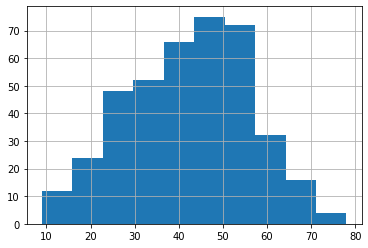

In [50]:
ptsd_df['SocialSupport'].hist()

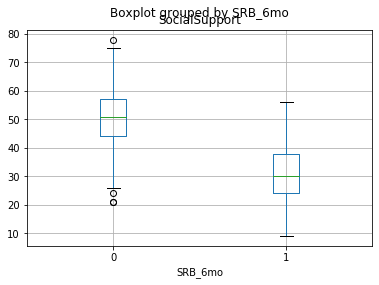

In [51]:
ptsd_df.boxplot(column='SocialSupport', by='SRB_6mo')

## (5) Generating Medication Data

In [52]:
ptsd_df.head()

,UID,PTSD_Q1_6mo,PTSD_Q2_6mo,PTSD_Q3_6mo,PTSD_Q4_6mo,PTSD_Q5_6mo,PTSD_Q6_6mo,PTSD_Q7_6mo,PTSD_Q8_6mo,PTSD_Q9_6mo,...,PTSD_Q20_6mo,PTSD_6mo,PHQ_Q9_6mo,SRB_6mo,Age,TimeFirstDiagnosis_Months,AlcAbuse,BeckAnxiety_BL,IncomeCat,SocialSupport
0,U200,1,0,0,0,0,1,0,1,0,...,0,0.0,0.0,0,29.0,18.0,0.0,24.0,<125% FPL,49.0
1,U398,0,1,2,2,0,1,0,3,0,...,2,0.0,0.0,0,45.0,17.0,1.0,0.0,400%+ FPL,59.0
2,Z812,2,1,1,2,0,1,1,0,0,...,4,0.0,0.0,0,39.0,18.0,0.0,21.0,125%-200% FPL,47.0
3,U221,0,0,0,0,1,1,2,1,3,...,0,0.0,0.0,0,54.0,24.0,0.0,0.0,<125% FPL,48.0
4,U338,2,1,0,1,1,0,0,0,0,...,0,0.0,2.0,1,20.0,16.0,1.0,2.0,200%-400% FPL,19.0


In [53]:
# Going to reverse engineer and the nlater clean up the data 
    # 1. Sample the indication of a for or against medication

for i in range(0, ptsd_df.shape[0]):
    if ptsd_df.loc[i, 'PTSD_6mo']==0 & ptsd_df.loc[i, 'SRB_6mo']==0:
        ptsd_df.loc[i, 'PTSD_MedInd'] = np.random.choice([0, 1], p=[0.2, 0.8])
        ptsd_df.loc[i, 'SRB_MedInd'] = np.random.choice([0, 1], p=[0.8, 0.2])
        
    if ptsd_df.loc[i, 'PTSD_6mo']==1 & ptsd_df.loc[i, 'SRB_6mo']==0:
        ptsd_df.loc[i, 'PTSD_MedInd'] = np.random.choice([0, 1], p=[0.7, 0.3])
        ptsd_df.loc[i, 'SRB_MedInd'] = np.random.choice([0, 1], p=[0.7, 0.3])
        
    if ptsd_df.loc[i, 'PTSD_6mo']==0 & ptsd_df.loc[i, 'SRB_6mo']==1:
        ptsd_df.loc[i, 'PTSD_MedInd'] = np.random.choice([0, 1], p=[0.3, 0.7])
        ptsd_df.loc[i, 'SRB_MedInd'] = np.random.choice([0, 1], p=[0.7, 0.3])
        
    if ptsd_df.loc[i, 'PTSD_6mo']==1 & ptsd_df.loc[i, 'SRB_6mo']==1:
        ptsd_df.loc[i, 'PTSD_MedInd'] = np.random.choice([0, 1], p=[0.7, 0.3])
        ptsd_df.loc[i, 'SRB_MedInd'] = np.random.choice([0, 1], p=[0.3, 0.7])


In [54]:
ptsd_df[['PTSD_MedInd', 'PTSD_6mo']].groupby(['PTSD_MedInd', 'PTSD_6mo']).size().reset_index(name='counts')

,PTSD_MedInd,PTSD_6mo,counts
0,0.0,0.0,130
1,0.0,1.0,52
2,1.0,0.0,128
3,1.0,1.0,27


In [55]:
ptsd_df[['SRB_MedInd', 'SRB_6mo']].groupby(['SRB_MedInd', 'SRB_6mo']).size().reset_index(name='counts')

,SRB_MedInd,SRB_6mo,counts
0,0.0,0,121
1,0.0,1,87
2,1.0,0,53
3,1.0,1,76


In [56]:
ptsd_df.sample(10)

,UID,PTSD_Q1_6mo,PTSD_Q2_6mo,PTSD_Q3_6mo,PTSD_Q4_6mo,PTSD_Q5_6mo,PTSD_Q6_6mo,PTSD_Q7_6mo,PTSD_Q8_6mo,PTSD_Q9_6mo,...,PHQ_Q9_6mo,SRB_6mo,Age,TimeFirstDiagnosis_Months,AlcAbuse,BeckAnxiety_BL,IncomeCat,SocialSupport,PTSD_MedInd,SRB_MedInd
230,U830,0,0,0,0,2,2,1,0,0,...,1.0,1,27.0,22.0,1.0,13.0,125%-200% FPL,40.0,1.0,1.0
206,Z525,1,0,0,0,0,1,0,3,0,...,2.0,1,20.0,24.0,0.0,1.0,<125% FPL,34.0,0.0,0.0
33,Z305,2,0,4,2,0,0,1,0,0,...,0.0,0,55.0,15.0,0.0,5.0,125%-200% FPL,44.0,1.0,0.0
263,U561,0,3,1,0,1,1,2,0,1,...,2.0,1,24.0,14.0,1.0,0.0,200%-400% FPL,34.0,1.0,1.0
91,U436,3,0,0,0,2,0,3,1,4,...,1.0,1,29.0,21.0,1.0,22.0,200%-400% FPL,25.0,0.0,1.0
187,Z267,0,3,1,1,0,2,2,1,0,...,1.0,1,25.0,20.0,0.0,6.0,<125% FPL,17.0,0.0,1.0
260,Z269,1,3,2,0,0,0,3,2,1,...,1.0,1,23.0,22.0,1.0,0.0,200%-400% FPL,27.0,0.0,0.0
175,U123,1,1,3,4,1,1,2,3,0,...,1.0,1,26.0,24.0,1.0,24.0,125%-200% FPL,26.0,0.0,1.0
400,U356,2,0,2,2,1,0,0,3,1,...,0.0,0,18.0,17.0,0.0,15.0,400%+ FPL,43.0,1.0,0.0
90,Z968,1,1,0,0,0,0,4,0,1,...,0.0,0,38.0,23.0,0.0,42.0,400%+ FPL,52.0,0.0,0.0


Now we will create the medications prescribed to individuals for the placeholder variables assigned above. First I'll create a brief dictionary of medications to include with differing probabilities, hopefully to lead to the relationships we want to explore when fitting our final models, and then I'll sample from this dictionary based on each patient's `SRB_MedInd` and `PTSD_MedInd` indicator variables:

In [57]:
med_dict = {
    'evidence_low':['midazolam', 'clonazepam'],
    'evidence_high':['nefazodone', 'phenelzine'],
    'evidence_against':['sertraline', 'paroxetine']
}

In [58]:
for i in range(0, ptsd_df.shape[0]):
    low_med = np.random.choice(med_dict['evidence_low'], 1)[0]
    high_med = np.random.choice(med_dict['evidence_high'], 1)[0]
    srb_med = np.random.choice(med_dict['evidence_against'], 1)[0]
    if (ptsd_df.loc[i, 'SRB_MedInd']==0) & (ptsd_df.loc[i, 'PTSD_MedInd']==0):
        ptsd_df.loc[i, 'PTSD_Rx'] = np.random.choice([srb_med, high_med, low_med], 1,
                                                     p=[0.1, 0.1, 0.8])
    elif (ptsd_df.loc[i, 'SRB_MedInd']==0) & (ptsd_df.loc[i, 'PTSD_MedInd']==1):
        ptsd_df.loc[i, 'PTSD_Rx'] = np.random.choice([srb_med, high_med, low_med], 1,
                                                     p=[0.1, 0.7, 0.2])
    elif (ptsd_df.loc[i, 'SRB_MedInd']==1) & (ptsd_df.loc[i, 'PTSD_MedInd']==0):
        ptsd_df.loc[i, 'PTSD_Rx'] = np.random.choice([srb_med, high_med, low_med], 1,
                                                     p=[0.7, 0.15, 0.15])
    elif (ptsd_df.loc[i, 'SRB_MedInd']==1) & (ptsd_df.loc[i, 'PTSD_MedInd']==1):
        ptsd_df.loc[i, 'PTSD_Rx'] = np.random.choice([srb_med, high_med, low_med], 1,
                                                     p=[0.42, 0.42, 0.16])


## (6) Data Export

In [59]:
# Removing those indicator variables
del ptsd_df['PTSD_MedInd']
del ptsd_df['SRB_MedInd']
del ptsd_df['PTSD_6mo']
del ptsd_df['SRB_6mo']

In [60]:
ptsd_df.columns

Index(['UID', 'PTSD_Q1_6mo', 'PTSD_Q2_6mo', 'PTSD_Q3_6mo', 'PTSD_Q4_6mo',
       'PTSD_Q5_6mo', 'PTSD_Q6_6mo', 'PTSD_Q7_6mo', 'PTSD_Q8_6mo',
       'PTSD_Q9_6mo', 'PTSD_Q10_6mo', 'PTSD_Q11_6mo', 'PTSD_Q12_6mo',
       'PTSD_Q13_6mo', 'PTSD_Q14_6mo', 'PTSD_Q15_6mo', 'PTSD_Q16_6mo',
       'PTSD_Q17_6mo', 'PTSD_Q18_6mo', 'PTSD_Q19_6mo', 'PTSD_Q20_6mo',
       'PHQ_Q9_6mo', 'Age', 'TimeFirstDiagnosis_Months', 'AlcAbuse',
       'BeckAnxiety_BL', 'IncomeCat', 'SocialSupport', 'PTSD_Rx'],
      dtype='object')

In [61]:
#ptsd_df[['PTSD_6mo', 'SRB_6mo']].groupby(['PTSD_6mo', 'SRB_6mo']).size().reset_index(name='counts')
ptsd_df.to_csv('PTSD_ResearchCohort.csv')
ptsd_df

,UID,PTSD_Q1_6mo,PTSD_Q2_6mo,PTSD_Q3_6mo,PTSD_Q4_6mo,PTSD_Q5_6mo,PTSD_Q6_6mo,PTSD_Q7_6mo,PTSD_Q8_6mo,PTSD_Q9_6mo,...,PTSD_Q19_6mo,PTSD_Q20_6mo,PHQ_Q9_6mo,Age,TimeFirstDiagnosis_Months,AlcAbuse,BeckAnxiety_BL,IncomeCat,SocialSupport,PTSD_Rx
0,U200,1,0,0,0,0,1,0,1,0,...,0,0,0.0,29.0,18.0,0.0,24.0,<125% FPL,49.0,clonazepam
1,U398,0,1,2,2,0,1,0,3,0,...,0,2,0.0,45.0,17.0,1.0,0.0,400%+ FPL,59.0,clonazepam
2,Z812,2,1,1,2,0,1,1,0,0,...,0,4,0.0,39.0,18.0,0.0,21.0,125%-200% FPL,47.0,clonazepam
3,U221,0,0,0,0,1,1,2,1,3,...,3,0,0.0,54.0,24.0,0.0,0.0,<125% FPL,48.0,sertraline
4,U338,2,1,0,1,1,0,0,0,0,...,1,0,2.0,20.0,16.0,1.0,2.0,200%-400% FPL,19.0,nefazodone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,Z866,0,0,1,4,3,1,1,1,2,...,1,0,0.0,46.0,21.0,0.0,13.0,125%-200% FPL,55.0,clonazepam
397,Z145,1,1,0,2,1,0,3,1,0,...,0,1,2.0,19.0,21.0,0.0,2.0,125%-200% FPL,46.0,phenelzine
398,Z232,0,1,0,0,0,0,3,2,1,...,0,1,3.0,19.0,21.0,1.0,12.0,400%+ FPL,29.0,phenelzine
399,U739,1,1,0,1,4,0,0,4,1,...,4,3,3.0,19.0,20.0,1.0,33.0,<125% FPL,22.0,nefazodone
